# Workflow & Hyperparameter Optimization

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import random

🏠 Import the house price data set. We will keep only numerical features for the sake of simplicity

🎯 Your goal will be to fit the best KNN Regressor. In particular, how many "neighbors" (<font color=blue>K</font> in <font color=blue>K</font>NN) should you consider to get the best predictions for your house prices ?

In [5]:
# Load raw data
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv')

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [7]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Train/Test split

❓ **Question (Holdout)**❓

👇 Split the dataset to create your `X_train` `X_test` and `y_train` `y_test`. Use:
- `test_size=0.3`
- `random_state=0` to compare your results with your buddy

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Scaling

⚖️ Scaling is always crucially important for the KNN algorithm..

❓ **Question (Scaling)** ❓ 

* Scale your train set and test set.
* Here, let's simply apply the `StandardScaler` and not waste time choosing one scaler per feature. Indeed, the goals of this exercise are to:
    * review KNN
    * understand GridSearchCV
    * understand RandomizedSearchCV

In [9]:
r_scaler = StandardScaler()
r_scaler.fit(X_train)
X_train_scaled = r_scaler.transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns = X.columns)
X_train_scaled.shape

(784, 37)

## 3. Baseline KNN model

❓ **Question (A baseline for our KNN)** ❓

Cross-validate (*cv = 5*) a simple KNN regressor taking into account only _the closest neighbor_, and compute the average score over the 5 folds.

In [10]:
neigh = KNeighborsRegressor(n_neighbors=1)

cv_results = cross_validate(neigh, X_train_scaled, y_train, cv=5)
base_knn_score = cv_results['test_score'].mean()
base_knn_score

0.569025195507008

## 4. GridSearch

### 4.1. A first GridSearch

❓ **Question (GridSearch v1)**❓

Let's use SKLearn `GridSearchCV` to find the best KNN hyperparameter `n_neighbors`.
- Start a coarse-grain approach, with `n_neighbors` = [1,5,10,20,50]
- 5-fold cross-validate each parameter
- Make sure to maximize your performance time using `n_jobs`

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Instanciate model
model = KNeighborsRegressor()

# Hyperparameter Grid
grid = {'n_neighbors': [1,5,10,20,50]}

# Instanciate Grid Search
search = GridSearchCV(model, grid, scoring = 'r2', cv = 10, n_jobs=-1 ) 

# Fit data to Grid Search
search.fit(X_train_scaled,y_train);


❓ **Question (best parameters)** ❓

According to the GridSearch, what is the optimal K value?

In [15]:
best_k = search.best_params_
best_k

{'n_neighbors': 20}

❓ **Question (scoring)** ❓ What is the best score the optimal K value produced?

In [14]:
best_score = search.best_score_
best_score

0.7685936824413232

❓ **Question (GridSearch V2)** ❓


Now, we have an idea about where the best $K$ lies, but some of the values we didn't try could result in a  better performance.

* Re-run a GridSearch trying some values for $K$ around to your previous best value
* What are the `best_score` and `best_k` for this refined GridSearch?

### 4.2. A second GridSearch

In [27]:
# Instantiate model
model = KNeighborsRegressor()

# Hyperparameter Grid
grid = {'n_neighbors': [13,14,15,16,17]}

# Instantiate Grid Search
search = GridSearchCV(model, grid, scoring = 'r2', cv=10, n_jobs=-1 ) 

# Fit data to Grid Search
search.fit(X_train_scaled,y_train);

best_k = search.best_params_['n_neighbors']
best_k


16

In [25]:
best_score = search.best_score_
best_score

0.7724899314806318

***🧪 Test your code***

In [28]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.1.2, pluggy-1.0.0 -- /bin/python3
cachedir: .pytest_cache
rootdir: /home/quantium/labs/lewagon/data-challenges/05-ML/05-Model-Tuning/01-Workflow/tests
plugins: dash-1.19.0, anyio-3.6.1
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.15s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



### 4.3. Visual check (manual GridSearch)

☝️ This problem is actually simple enough to perform a GridSearch manually.

❓ **Question(Manual GridSearch)** ❓

- Loop manually over all values of $K$ from $1$ to $50$ and store the average of the cross-validated scores of each model in a list.
- Plot the scores as a function of $K$ to visually find the best $K$ using the `Elbow Method`

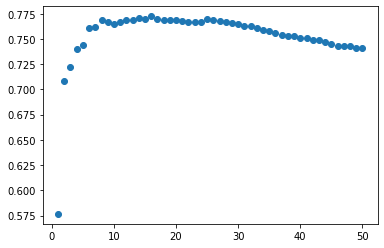

In [36]:
n = 50
Ks = []
for i in range(1, n+1):
    model = KNeighborsRegressor(n_neighbors=i)
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=10, n_jobs=-1)
    Ks.append(cv_results['test_score'].mean())

plt.scatter(x=range(1, n+1), y=Ks);

❓Can you guess what makes GridSearchCV a better option than such manual loop ?


<details>
    <summary>Answer</summary>

- Sklearn's `n_jobs=-1` allows you to paralellize the search, utilizing all of your CPU cores
- What if you had multiple hyper-parameters to co-optimize?
</details>

## 5. GridSearch with multiple parameters

👩🏻‍🏫 KNNRegressor suppports various _distance metrics_ via the hyper-parameter `p` 

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Question (tuning multiple parameters)** ❓


* Use GridSearchCV to search for the best $K$ and $p$ simultaneously.
    * Try all combinations for $K = [1, 5, 10, 20, 50]$ and $p = [1, 2, 3]$. 

In [37]:
# Instantiate model
model = KNeighborsRegressor()

# Hyperparameter Grid
grid = {'n_neighbors': [1,5,10,20,50], 'p': [1, 2, 3]}

# Instantiate Grid Search
search = GridSearchCV(model, grid, scoring = 'r2', cv=10, n_jobs=-1 ) 

# Fit data to Grid Search
search.fit(X_train_scaled,y_train);

10

❓ **Question (number of submodels)**❓

How many submodels did you train overall?

<details>
    <summary>Hint</summary>

Much more than 15. Think twice :)
    <details>
    <summary>Answer</summary>

75 models due to CV=5
</details>

In [56]:
from itertools import product

len(list(product(grid['n_neighbors'], grid['p'])))*5

75

❓ **Question (best parameters and best score after tuning the model with multiple parameters)**❓

What are the *best parameters* and the *best score*?

In [61]:
best_params = search.best_params_
best_params

{'n_neighbors': 2, 'p': 1}

In [62]:
best_score = search.best_score_
best_score

0.8107808834152845

## 6. Random Search

Now let's see whether a RandomizedSearch can find a better combination with the same number of models being fitted.

❓ **Question (RandomizedSearchCV)** ❓

Use `RandomizedSearchCV` to
- Randomly sample $K$ from a uniform `randint(1,50)` distribition
- Sample $p$ from a list $[1,2,3]$
- Use the correct numbers of `n_iter` and `cv` to fit the exact same numbers of models as in your previous GridSearchCV.

In [78]:
# Instantiate model
model = KNeighborsRegressor()

# Hyperparameter Grid
grid = {'n_neighbors': range(1,51), 'p': [1, 2, 3]}

# Instantiate Grid Search
search = RandomizedSearchCV(model, grid, scoring = 'r2', cv=10, n_jobs=-1 ) 

# Fit data to Grid Search
search.fit(X_train_scaled,y_train);

In [66]:
best_params = search.best_params_
best_params

{'n_neighbors': 2, 'p': 1}

In [67]:
best_score = search.best_score_
best_score

0.8107808834152845

## 7. Generalization

❓ **Question (finetuning your model one more time)**❓

- Refine your RandomsearchCV if you want
- Choose your best model

In [69]:
X_test_scaled = r_scaler.transform(X_test)

best_model = search.best_estimator_
best_model.fit(X_train_scaled, y_train);

Now try to display your `cv_results` as a `DataFrame`, this will help you visualize what's going on inside the CV! 😉

In [75]:
cv_results = cross_validate(model, X_train_scaled, y_train, cv=10, n_jobs=-1)
cv_results

{'fit_time': array([0.00384569, 0.00337863, 0.0040226 , 0.00411272, 0.0135386 ,
        0.00424862, 0.00442839, 0.0038693 , 0.00392294, 0.00389767]),
 'score_time': array([0.04136753, 0.0404551 , 0.00606394, 0.00562406, 0.00546336,
        0.00523376, 0.00760508, 0.00520349, 0.00483108, 0.00458837]),
 'test_score': array([0.80759144, 0.52120046, 0.78580166, 0.78559314, 0.55210938,
        0.79363315, 0.8578987 , 0.85175014, 0.86902272, 0.62000474])}

❓ **Question (Evaluation of the "best" model)** ❓

* Time has come to discover our model's performance with "best params" on the **unseen** test set `X_test`.
    * Compute the r2 score for the test set and save it as `r2_test`.

In [73]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, best_model.predict(r_scaler.transform(X_test)))
r2_test

/home/quantium/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


0.7501375248102157

❓ **Question (Taking a step back)** ❓

Would you consider the optimized model to generalize well?

<details><summary>Answer</summary>

Test score may decrease a bit with train set. Probably not more than 5%. This can be due to
- A non-representative train/test split
- A cross-val number too small leading to overfitting the model-tuning phase. The more you cross-validated, the more robust your findings will generalize - but you can't increase cv too much if your dataset is too small as you won't keep enough observations in each fold to be representative.
- Our dataset is very small and our hyperparameter optimization is thus extremely dependent (and overfitting) on our train/test split. Always make sure your dataset is much bigger than the total number of hyperparameter combinations you are trying out!
    
</details>

***🧪 Test your code***

In [76]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.1.2, pluggy-1.0.0 -- /bin/python3
cachedir: .pytest_cache
rootdir: /home/quantium/labs/lewagon/data-challenges/05-ML/05-Model-Tuning/01-Workflow/tests
plugins: dash-1.19.0, anyio-3.6.1
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.19s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master



🏁 Congratulations! Now, you know how to finetune a model using either a GridSearchCV or a RandomizedSearchCV 

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!